In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import *
#import time

#Conversions

# 1 year = 31536000 s
# 1 pc = 3.086e16 m
# 1 M_sun = 1.989e30 kg

#Some Constants Used Throughout

t_obsy = 4                  #years
t_obs = t_obsy*31536000     #s
v_t = 6.481*10**(-12)       #pc/s
d_l = 50                    #pc
d_s = 2000                  #pc
c = 9.721*10**(-9)          #pc/s
G = 4.517*10**(-30)         #pc^3/(s^2*M_sun)
sigv = 3*10**(-28)          #cm^3/s
m_chi = 100                 #GeV

Smin = []                   #The four cutoffs of Smin, in arcseconds
Smin.append(4*10**(-6))
Smin.append(16*10**(-6))
Smin.append(64*10**(-6))
Smin.append(256*10**(-6))

#Some Parameters

N_epoch = 55                #Number of Epochs
rho_0 = 2.0*10**8           #Maximum core density from dark matter annihilation (M_sun/pc^3)

N_coords = 10
N_int = 10
N_equil = 10
beta_twid_max = 1000
scale = d_l/(v_t*t_obs)

#m_test = 1
#Rt_test = r_t(m_test)
#Rc_test = r_c(m_test)

#Some Functions Used Throughout

def r_t(m):                                        #Truncation Radius in pc
    return (0.019*(1000/1)*(m*(1+3250))**(1/3))

def r_c(m):                                        #Core Radius in pc
    return (3.3*10**(-4)*m**(1/3))

def rho(r,m):                                      #Density in M_sun/pc^3
    if(r < r_t(m)):
        return (rho_0*(1+r/(r_c(m)))**(-9/4))
    else:
        return 0

def M2D(xi, z, Rc):                                    #M2D function
    return 4*np.pi*rho_0*(1+(np.sqrt((xi**2) + (z**2))/Rc))**(-9/4)*xi

def func(xi, Rt):                                      #Boundary function in M2D integral
    return np.sqrt(Rt**2 - xi**2)

def mass_V(xi, Rt):
    return ( (xi*np.sqrt(Rt**2 - xi**2))/2 + (Rt**2)/2*np.arcsin(xi/Rt) )

def beta_mag(by, bx):
    return np.sqrt(bx**2 + by**2)

def MC_int(xi_r, z_r, Rc, xi, Rt):
    return 1/(N_int-1)*M2D(xi_r,z_r, Rc)/mass_V(xi, Rt)

In [2]:
def Mass_Plot(M):  
    Rt = r_t(M)
    Rc = r_c(M)
    
    count = np.zeros(4)        #Resetting the Monte Carlo counter for successful Signals

    A_lens = np.zeros(4)       #Resetting the lensed area for successful signals

    for i in range(N_coords):
        phi = randint(0,1)/10
        beta_twid = randint(0,beta_twid_max)/10

        S_sq = 0
        
        alpha = np.zeros(N_epoch)

        for j in range(N_epoch):
            beta_y = beta_twid/scale
            beta_x = phi/scale
            beta = beta_mag(beta_y, beta_x)
            
            if( beta_y < Rt ) and ( beta > 0 ):
                xi_true = d_l*beta
                #print(xi_true)

                xi = np.random.uniform(0,xi_true)  #initializing MCMC
                z = np.random.uniform(0,np.sqrt(Rt**2-xi_true**2))
                
                sig_xi = xi_true/10
                sig_z = np.sqrt(Rt**2-xi_true**2)/500
                
                xipts, zpts = np.zeros(N_int+1), np.zeros(N_int+1)
                xipts[0], zpts[0] = xi,z

                for k in range(N_equil):
                    xi_new = np.random.normal(xi,sig_xi)
                    z_new = np.random.normal(z,sig_z)

                    while ((xi_new > xi_true) or (xi_new < 0)):
                        xi_new = np.random.normal(xi,sig_xi)
                    while ((z_new < 0) or (z_new > np.sqrt(Rt**2-xi_new**2))):
                        z_new = np.random.normal(z,sig_z)

                    prob = M2D(xi_new,z_new, Rc)/M2D(xi,z,Rc)

                    if np.random.uniform() < prob:
                        xi,z = xi_new,z_new

                for l in range(N_int):
                    xi_new = np.random.normal(xi,sig_xi)
                    z_new = np.random.normal(z,sig_z)

                    while ((xi_new > xi_true) or (xi_new < 0)):
                        xi_new = np.random.normal(xi,sig_xi)
                    while ((z_new < 0) or (z_new > np.sqrt(Rt**2-xi_new**2))):
                        z_new = np.random.normal(z,sig_z)

                    prob = M2D(xi_new,z_new, Rc)/M2D(xi,z,Rc)

                    if np.random.uniform() < prob:
                        xi,z = xi_new,z_new

                    xipts[i+1], zpts[i+1] = xi,z

            Mass_int = (1/(N_int+1))*np.sum(mass_V(xipts, Rt)*M2D(xipts,zpts,Rc))

            #if( beta_y < Rt ) and ( beta > 0 ):
             #   xi = d_l*beta

             #   Mass_int = 0
                
              #  xi_rand = np.random.uniform(0, xi, N_int)
               # z_rand = np.random.uniform(0, func(xi, Rt), N_int)
                
                #Mass_int = np.sum(MC_int(xi_rand, z_rand, Rc, xi, Rt))
                    
            alpha[j] = np.abs((1-d_l/d_s)*(4*G*Mass_int)/(c**2*xi_true))

            beta_x -= v_t*t_obs/N_epoch

        S = np.sqrt(np.sum(alpha))
        
        count += (S > Smin)

    A_lens = (count/N_coords)*(beta_twid_max)  #Hits/Total * (b, p) area
    
    return A_lens[3],A_lens[2],A_lens[1],A_lens[0]


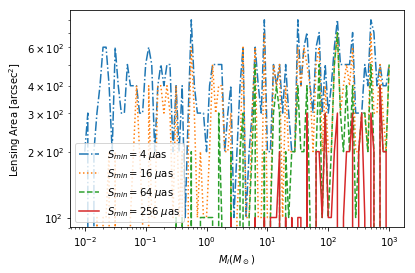

In [3]:
mass_range = np.logspace(-2,3,101)
Area_4 = np.zeros(np.size(mass_range))
Area_16 = np.zeros(np.size(mass_range))
Area_64 = np.zeros(np.size(mass_range))
Area_256 = np.zeros(np.size(mass_range))

for a in range(np.size(mass_range)):
    Area_256[a], Area_64[a], Area_16[a], Area_4[a] = Mass_Plot(mass_range[a])
    
    print("{0} remaining iterations".format(np.size(mass_range) - a), end="\r")
    
Area_4_np = np.array(Area_4)
Area_16_np = np.array(Area_16)
Area_64_np = np.array(Area_64)
Area_256_np = np.array(Area_256)


plt.plot(mass_range, Area_4, label = '$S_{min} = 4\; \mu$as', linestyle = '-.')
plt.plot(mass_range, Area_16, label = '$S_{min} = 16\; \mu$as', linestyle = ':')
plt.plot(mass_range, Area_64, label = '$S_{min} = 64\; \mu$as', linestyle = '--')
plt.plot(mass_range, Area_256, label = '$S_{min} = 256\; \mu$as')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_i(M_\odot)$')
plt.ylabel('Lensing Area [arcsec$^2$]')
plt.legend()
plt.show()

In [4]:
def h(x,y):
    """
    x^2y from 0 to x, 1 to 3
    """
    return x**2*y

def V():
    """
    Essentially 1/pdf of the above function
    """
    return 4

"""
This is a test of the Metropolis integration on the above test function
"""

N_test = 10000
N_eq = 2000

x, y = 1, 1 #initializing MCMC
sig_x, sig_y = 0.5, 0.5

xpts, ypts = np.zeros(N_test+1), np.zeros(N_test+1)
xpts[0], ypts[0] = x,y

for j in range(N_eq):
    x_new = np.random.normal(x,sig_x)
    y_new = np.random.normal(y,sig_y)
        
    while ((x_new > 3) or (x_new < 1)):
        x_new = np.random.normal(x,sig_x)
    while ((y_new < 0) or (y_new > x_new)):
        y_new = np.random.normal(y,sig_y)
    
    alpha = h(x_new,y_new)/h(x,y)
    
    if np.random.uniform() < alpha:
        x,y = x_new,y_new

for i in range(N_test):
    x_new = np.random.normal(x,sig_x)
    y_new = np.random.normal(y,sig_y)
    
    while ((x_new > 3) or (x_new < 1)):
        x_new = np.random.normal(x,sig_x)
    while ((y_new < 0) or (y_new > x_new)):
        y_new = np.random.normal(y,sig_y)
    
    alpha = h(x_new,y_new)/h(x,y)
    
    if np.random.uniform() < alpha:
        x,y = x_new,y_new
    
    xpts[i+1], ypts[i+1] = x,y
    
I = (V()/(N_test+1))*np.sum(h(xpts,ypts))

I

32.34262891272707

In [5]:
"""
This is the same integral, using uniform MC

The correct evaluation should yield 24.2
"""

x_rand = np.random.uniform(1, 3, N_test)
y_rand = np.random.uniform(0, x_rand, N_test)
                
I = V()/N_test*np.sum(h(x_rand,y_rand))

I

19.773670759421496

In [6]:
"""
Uniform MC for a sample M2D integral
"""

Rt = r_t(10)
Rc = r_c(10)

print(Rt, Rc)

phi = randint(0,1)/10
beta_twid = randint(0,beta_twid_max)/10

beta_y = beta_twid/scale
beta_x = phi/scale
beta = beta_mag(beta_y, beta_x)

if( beta_y < Rt ) and ( beta > 0 ):
    xi = d_l*beta
    
    print(xi)
    

    Mass_int = 0
                
    xi_rand = np.random.uniform(0, xi, N_int)
    z_rand = np.random.uniform(0, func(xi, Rt), N_int)
                
    Mass_int = np.sum(MC_int(xi_rand, z_rand, Rc, xi, Rt))
    
Mass_int

606.400090517898 0.0007109634477105217
0.0434930888448


1.3276596942842426e-06

In [7]:
"""
Metropolis integration for M2D

Mathematica gives O(10^2) answers
"""

Rt = r_t(10)
Rc = r_c(10)

N_test = 10000
N_eq = 1000

I=0

phi = randint(0,1)/10
beta_twid = randint(0,beta_twid_max)/10

beta_y = beta_twid/scale
beta_x = phi/scale
beta = beta_mag(beta_y, beta_x)

if( beta_y < Rt ) and ( beta > 0 ):
    xi_true = d_l*beta
    print(xi_true)
    
    xi = 0.5*xi_true  #initializing MCMC
    z = 0.5*np.sqrt(Rt**2-xi_true**2)
    
    sig_xi = xi_true/10
    sig_z = np.sqrt(Rt**2-xi_true**2)/100
    
    xipts, zpts = np.zeros(N_test+1), np.zeros(N_test+1)
    xipts[0], zpts[0] = xi,z
    
    for j in range(N_eq):
        xi_new = np.random.normal(xi,sig_xi)
        z_new = np.random.normal(z,sig_z)

        while ((xi_new > xi_true) or (xi_new < 0)):
            xi_new = np.random.normal(xi,sig_xi)
        while ((z_new < 0) or (z_new > np.sqrt(Rt**2-xi_new**2))):
            z_new = np.random.normal(z,sig_z)

        prob = M2D(xi_new,z_new, Rc)/M2D(xi,z,Rc)

        if np.random.uniform() < prob:
            xi,z = xi_new,z_new

    for i in range(N_test):
        xi_new = np.random.normal(xi,sig_xi)
        z_new = np.random.normal(z,sig_z)

        while ((xi_new > xi_true) or (xi_new < 0)):
            xi_new = np.random.normal(xi,sig_xi)
        while ((z_new < 0) or (z_new > np.sqrt(Rt**2-xi_new**2))):
            z_new = np.random.normal(z,sig_z)

        prob = M2D(xi_new,z_new, Rc)/M2D(xi,z,Rc)

        if np.random.uniform() < prob:
            xi,z = xi_new,z_new

        xipts[i+1], zpts[i+1] = xi,z
    
    I = (1/(N_test+1))*np.sum(mass_V(xipts, Rt)*M2D(xipts,zpts,Rc))

    print(I)

0.07733925758470843
131588.77210623617
